# Práctica 2 - Self-Organising Maps
## Preparación de entorno
#### Importar librerías de código

In [62]:
%pip install numpy matplotlib pandas mpl_toolkits.mplot3d

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mpl_toolkits.mplot3d (from versions: none)
ERROR: No matching distribution found for mpl_toolkits.mplot3d

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\Users\javie\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [63]:

# from __future__ import division
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from mpl_toolkits.mplot3d import Axes3D


#### Dataset que se va a utilizar para el entrenamiento

In [64]:
# Carga el archivo CSV
dataset_path = "pokemon_train.csv"
data = pd.read_csv(dataset_path)

# Elimina las columnas 'name', 'type1', 'type2' e 'id'
columnas_a_eliminar = ['name', 'type1', 'type2', 'id']
data = data.drop(columns=columnas_a_eliminar, errors='ignore')  # Elimina las columnas indicadas

# Muestra las primeras filas del dataset para inspeccionarlo
print("Primeras filas del dataset")
print(data.head())



Primeras filas del dataset
   against_bug  against_dark  against_dragon  against_electric  against_fairy  \
0          1.0           1.0             1.0               0.5            0.5   
1          1.0           1.0             1.0               0.5            0.5   
2          1.0           1.0             1.0               0.5            0.5   
3          0.5           1.0             1.0               1.0            0.5   
4          0.5           1.0             1.0               1.0            0.5   

   against_fight  against_fire  against_flying  against_ghost  against_grass  \
0            0.5           2.0             2.0            1.0           0.25   
1            0.5           2.0             2.0            1.0           0.25   
2            0.5           2.0             2.0            1.0           0.25   
3            1.0           0.5             1.0            1.0           0.50   
4            1.0           0.5             1.0            1.0           0.50   

   ag

## SOM Setup
#### Variables definidas por el alumno

In [65]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 40
periodo = 25000
learning_rate = 0.5
normalizar_datos = True


In [66]:
# Seleccionar las columnas 'against_*'
columnas_relevantes = [col for col in data.columns if "against_" in col]
datos = data[columnas_relevantes].values  # Convertir a un array NumPy
# Normalización del dataset (valores entre 0 y 1)
datos_normalizados = datos / datos.max(axis=0)
# Establece el número de datos y entradas
num_datos = datos_normalizados.shape[0]  # Número de patrones de entrada
num_entradas = datos_normalizados.shape[1]  # Dimensiones de las características (18 en este caso)

print(f"Datos cargados: {num_datos} patrones, {num_entradas} dimensiones.")

# Crea una matriz de pesos aleatorios entre 0 y 1
matriz_pesos = np.random.random((lado_mapa, lado_mapa, num_entradas))


Datos cargados: 247 patrones, 18 dimensiones.


In [67]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patron_entrada, matriz_pesos, num_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bmu_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, matriz_pesos, num_entradas):
    distancia_min = float('inf')  # Inicializa la distancia mínima como infinita
    bmu_idx = np.zeros(2, dtype=int)  # Coordenadas de la BMU (índices i, j)
    bmu = np.zeros(num_entradas)  # Vector de pesos de la BMU
    
    # Recorre todas las neuronas del mapa
    for i in range(matriz_pesos.shape[0]):  # Filas de la matriz de pesos
        for j in range(matriz_pesos.shape[1]):  # Columnas de la matriz de pesos
            # Calcula la distancia euclídea entre el patrón de entrada y el vector de pesos de la neurona
            distancia_euclidea = np.linalg.norm(patron_entrada - matriz_pesos[i, j])
            
            # Si la distancia es menor que la mínima encontrada hasta ahora, actualiza la BMU
            if distancia_euclidea < distancia_min:
                distancia_min = distancia_euclidea
                bmu_idx = [i, j]  # Guarda las coordenadas de la neurona ganadora
                bmu = matriz_pesos[i, j]  # Guarda el vector de pesos de la BMU
    
    return bmu, bmu_idx


In [68]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)



def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    learning_rate_i = lr_inicial * (1 - (i/n_iteraciones))
    return learning_rate_i


In [69]:
# Función decay para calcular la influencia
def decay(distancia_BMU, vecindario_actual):
    if vecindario_actual <= 0:
        return 0
    return np.exp(-(distancia_BMU ** 2) / (2 * (vecindario_actual ** 2)))


In [70]:
# Cálculo del error de cuantificación
def calcular_error_cuantificacion(datos, matriz_pesos):
    error_total = 0
    for patron in datos:
        _, bmu_idx = calcular_bmu(patron, matriz_pesos, num_entradas)
        error_total += np.linalg.norm(patron - matriz_pesos[bmu_idx[0], bmu_idx[1]])
    return error_total / len(datos)



In [71]:
# Cálculo del error topológico mejorado
def calcular_error_topologico(datos, matriz_pesos):
    error_total = 0
    for patron in datos:
        _, bmu_idx = calcular_bmu(patron, matriz_pesos, num_entradas)

        # Obtener vecinos válidos (sin contar la BMU)
        vecinos = [
            (bmu_idx[0] + dx, bmu_idx[1] + dy)
            for dx in [-1, 0, 1] for dy in [-1, 0, 1]
            if 0 <= bmu_idx[0] + dx < lado_mapa and 0 <= bmu_idx[1] + dy < lado_mapa and (dx, dy) != (0, 0)
        ]

        # Si no hay vecinos, continuar con el siguiente patrón
        if not vecinos:
            continue

        # Calcular distancias a vecinos
        distancias = [
            np.linalg.norm(matriz_pesos[bmu_idx[0], bmu_idx[1]] - matriz_pesos[x, y])
            for x, y in vecinos
        ]

        # Promediar las dos distancias más pequeñas en lugar de tomar solo la mínima
        min_dist = np.mean(sorted(distancias)[:2])  

        error_total += min_dist

    return error_total / len(datos)


In [72]:
def entrenar_som(matriz_pesos, datos, n_iteraciones, learning_rate, lado_mapa):
    vecindario_inicial = lado_mapa / 2  # Radio inicial del vecindario

    for i in range(n_iteraciones):
        # Seleccionar un patrón de entrada aleatorio
        indice_random = np.random.randint(0, len(datos))
        patron_entrada = datos[indice_random]

        # Encontrar la BMU
        _, bmu_idx = calcular_bmu(patron_entrada, matriz_pesos, num_entradas)

        # Actualizar learning rate y vecindario
        lr_actual = variacion_learning_rate(learning_rate, i, n_iteraciones)
        vecindario_actual = vecindario_inicial * (1 - (i / n_iteraciones))

        # Actualizar pesos
        for x in range(lado_mapa):
            for y in range(lado_mapa):
                # Calcular la distancia euclídea a la BMU
                distancia_bmu = np.linalg.norm(np.array([x, y]) - np.array(bmu_idx))

                # Si la neurona está dentro del vecindario, actualizar pesos
                if distancia_bmu <= vecindario_actual:
                    influencia = decay(distancia_bmu, vecindario_actual)
                    matriz_pesos[x, y] += lr_actual * influencia * (patron_entrada - matriz_pesos[x, y])

        # Mostrar errores cada 1000 iteraciones
        if i % 1000 == 0 or i == n_iteraciones - 1:
            error_cuantificacion = calcular_error_cuantificacion(datos, matriz_pesos)
            error_topologico = calcular_error_topologico(datos, matriz_pesos)
            print(f"Iteración {i}: Error de cuantificación = {error_cuantificacion:.4f}, Error topológico = {error_topologico:.4f}")

    return matriz_pesos

# Llamar a la función de entrenamiento
matriz_pesos_entrenada = entrenar_som(matriz_pesos, datos_normalizados, periodo, learning_rate, lado_mapa)


Iteración 0: Error de cuantificación = 0.7071, Error topológico = 0.7785
Iteración 1000: Error de cuantificación = 0.5516, Error topológico = 0.0404
Iteración 2000: Error de cuantificación = 0.5339, Error topológico = 0.0572
Iteración 3000: Error de cuantificación = 0.5078, Error topológico = 0.0577
Iteración 4000: Error de cuantificación = 0.5147, Error topológico = 0.0375
Iteración 5000: Error de cuantificación = 0.4850, Error topológico = 0.0527
Iteración 6000: Error de cuantificación = 0.4784, Error topológico = 0.0550
Iteración 7000: Error de cuantificación = 0.4140, Error topológico = 0.0964
Iteración 8000: Error de cuantificación = 0.4295, Error topológico = 0.0613
Iteración 9000: Error de cuantificación = 0.3998, Error topológico = 0.0645
Iteración 10000: Error de cuantificación = 0.3785, Error topológico = 0.1009
Iteración 11000: Error de cuantificación = 0.3239, Error topológico = 0.0928
Iteración 12000: Error de cuantificación = 0.3128, Error topológico = 0.0738
Iteración 13

In [73]:
# Cargar el dataset de clasificación
dataset_classify_path = "pokemon_classify.csv"
data_classify = pd.read_csv(dataset_classify_path)

# Eliminar las mismas columnas que se eliminaron en el entrenamiento
columnas_a_eliminar = ['name', 'type1', 'type2', 'id']
data_classify = data_classify.drop(columns=columnas_a_eliminar, errors='ignore')

# Seleccionar las columnas 'against_*'
columnas_relevantes_clasificar = [col for col in data_classify.columns if "against_" in col]
datos_clasificar = data_classify[columnas_relevantes_clasificar].values  # Convertir a NumPy array

# Normalización de los datos (usando el mismo método del entrenamiento)
datos_clasificar_normalizados = datos_clasificar / datos_clasificar.max(axis=0)

# Función para clasificar usando el SOM entrenado
def clasificar_som(datos_clasificar, matriz_pesos):
    clasificaciones = []
    
    for patron in datos_clasificar:
        _, bmu_idx = calcular_bmu(patron, matriz_pesos, num_entradas)
        clasificaciones.append(bmu_idx)  # Guardamos la coordenada de la BMU asignada
    
    return clasificaciones

# Clasificar los nuevos datos
clasificaciones = clasificar_som(datos_clasificar_normalizados, matriz_pesos_entrenada)

# Mostrar los primeros resultados en consola
print("Resultados de clasificación:")
for i, bmu in enumerate(clasificaciones[:10]):  # Mostrar solo los primeros 10 para no saturar la salida
    print(f"Pokémon {i+1} asignado a BMU: {bmu}")



Resultados de clasificación:
Pokémon 1 asignado a BMU: [34, 3]
Pokémon 2 asignado a BMU: [2, 39]
Pokémon 3 asignado a BMU: [39, 35]
Pokémon 4 asignado a BMU: [28, 7]


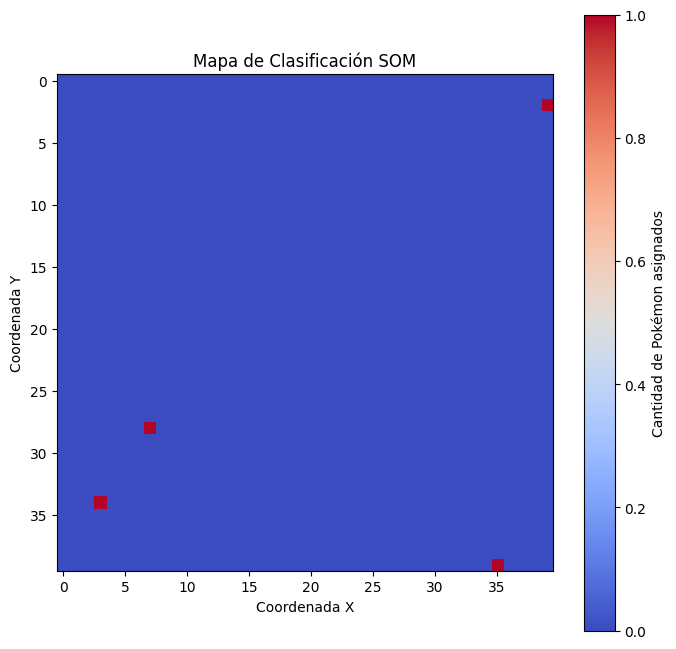

In [74]:
# === VISUALIZAR EL MAPA DE CLASIFICACIÓN ===
def visualizar_mapa_clasificacion(clasificaciones, lado_mapa):
    # Crear una matriz vacía para el mapa de clasificación
    mapa_clasificacion = np.zeros((lado_mapa, lado_mapa))

    for bmu in clasificaciones:
        x, y = bmu
        mapa_clasificacion[x, y] += 1  # Contar cuántos Pokémon caen en cada neurona

    # Dibujar el mapa con Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(mapa_clasificacion, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Cantidad de Pokémon asignados")
    plt.title("Mapa de Clasificación SOM")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.show()

# Llamar a la función para visualizar el mapa
visualizar_mapa_clasificacion(clasificaciones, lado_mapa)

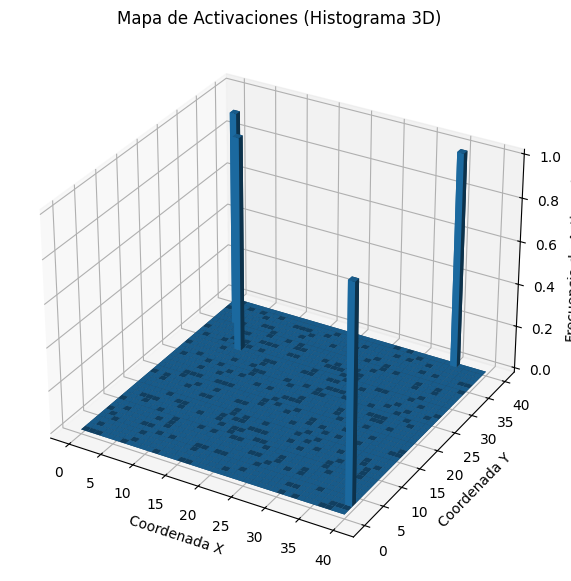

In [76]:

from matplotlib import cm

def mapa_activaciones_3d(clasificaciones, lado_mapa):
    # Crear una matriz vacía para contar las activaciones (BMUs)
    activaciones = np.zeros((lado_mapa, lado_mapa))

    # Contar las activaciones por cada BMU
    for bmu in clasificaciones:
        x, y = bmu
        activaciones[x, y] += 1

    # Preparar las coordenadas para el gráfico 3D
    x, y = np.meshgrid(range(lado_mapa), range(lado_mapa))
    z = activaciones

    # Crear la figura 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Crear el histograma 3D
    ax.bar3d(x.flatten(), y.flatten(), np.zeros_like(z.flatten()), 1, 1, z.flatten(), cmap=cm.coolwarm, shade=True)

    # Etiquetas y título
    ax.set_xlabel("Coordenada X")
    ax.set_ylabel("Coordenada Y")
    ax.set_zlabel("Frecuencia de Activación")
    ax.set_title("Mapa de Activaciones (Histograma 3D)")

    plt.show()
    
# Generar el mapa de activaciones en 3D
mapa_activaciones_3d(clasificaciones, lado_mapa)


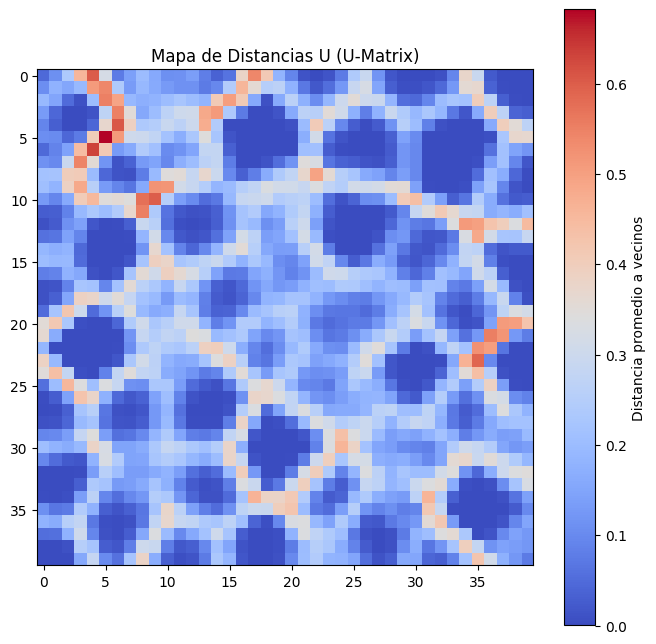

In [ ]:
def calcular_mapa_distancias(matriz_pesos):
    lado_mapa = matriz_pesos.shape[0]
    mapa_distancias = np.zeros((lado_mapa, lado_mapa))

    for i in range(lado_mapa):
        for j in range(lado_mapa):
            vecinos = []
            if i > 0:
                vecinos.append(matriz_pesos[i - 1, j])  # Arriba
            if i < lado_mapa - 1:
                vecinos.append(matriz_pesos[i + 1, j])  # Abajo
            if j > 0:
                vecinos.append(matriz_pesos[i, j - 1])  # Izquierda
            if j < lado_mapa - 1:
                vecinos.append(matriz_pesos[i, j + 1])  # Derecha

            # Promedio de distancias euclídeas a los vecinos
            distancias = [np.linalg.norm(matriz_pesos[i, j] - vecino) for vecino in vecinos]
            mapa_distancias[i, j] = np.mean(distancias) if distancias else 0

    return mapa_distancias

def graficar_mapa_distancias(matriz_pesos):
    mapa_distancias = calcular_mapa_distancias(matriz_pesos)

    plt.figure(figsize=(8, 8))
    plt.imshow(mapa_distancias, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Distancia promedio a vecinos")
    plt.title("Mapa de Distancias U (U-Matrix)")
    plt.show()

# Llamar a la función para graficar el mapa de distancias
graficar_mapa_distancias(matriz_pesos_entrenada)


In [ ]:
# === CÁLCULO DE ERRORES DESPUÉS DE LA CLASIFICACIÓN ===
# Calcular error de cuantificación
error_cuantificacion_final = calcular_error_cuantificacion(datos_clasificar_normalizados, matriz_pesos_entrenada)
print(f"Error de cuantificación después de la clasificación: {error_cuantificacion_final:.4f}")

# Calcular error topológico
error_topologico_final = calcular_error_topologico(datos_clasificar_normalizados, matriz_pesos_entrenada)
print(f"Error topológico después de la clasificación: {error_topologico_final:.4f}")


Error de cuantificación después de la clasificación: 1.6032
Error topológico después de la clasificación: 0.1007
